<div style="text-align: center">
    <img src="../figures/JuliaEO2024_banner.png" alt="Descriptive Image Text" style="border:1px solid black"/>
</div>



The objectives of this workshop are the following:


- **Understand SAR Imagery**: Gain an understanding of SAR imagery, its properties, and why it's advantageous for maritime surveillance.
- **Data Handling**: Learn how to acquire and prepare SAR data from the Sentinel-1 satellite.
- **Apply Machine Learning**: Explore machine learning techniques, from basic classification to object detection models.
- **Real-World Application**: Gain practical skills in applying these models to real-world SAR data for effective maritime surveillance.



____________________



## Notebooks

- 1: [Sentinel-1 data acquisition](1_Data_acqusition.ipynb)
- 2: [Ship binary classification](2_Ship_binary_classification.ipynb)
- 3: [Two stage ship detection](3_two_stage_ship_detector.ipynb)
- 4: [One stage ship detection](4_One_stage_ship_detector.ipynb)

<div style="text-align: center">
    <img src="../figures/overview_notebooks.png" alt="Descriptive Image Text" width="800" />
</div>



# Two stage ship detection
 <a class="anchor" id="toc"></a>
-  [Objectives](#Objectives)
-  [Two stage ship detector intro](#one_stage_object)
-  [Include modules](#init)
-  [Data](#data)
-  [Stage 1](#Transformations)
-  [Stage 2](#inferrence)




## Objectives
 <a class="anchor" id="Objectives"></a>
 Back to [Table of Content](#toc)


The objectives of this notebook are the following:
1. Combine the ship classifier from [Ship binary classification](2_Ship_binary_classification.ipynb) with an object detector (here CA-CFAR)
2. Apply the two stage ship detector to a Sentinel-1 image


## Two stage ship detector intro
Back to [Table of Content](#toc)



The two-stage ship detection workflow represents a traditional approach where the first stage is dedicated to object detection, here performed using Constant False Alarm Rate (CA-CFAR), and the second stage involves binary classification using a convolutional neural network (CNN).

 *1. First Stage: CA-CFAR Object Detection*

- **CA-CFAR Technique**: This radar processing technique is utilized to detect objects against a varying background noise level. It adapts the detection threshold automatically, aiming to maintain a constant false alarm rate regardless of the background noise.
- **Initial Detection**: The algorithm scans through the radar imagery to flag potential areas of interest where objects may be present.

This stage could be changed to a more advanced CA-CFAR(using convolutions), or a 2d wavelet transform etc.

*2. Second Stage: Binary Classification*

- **Binary CNN Classifier**: The flagged areas from the CA-CFAR stage are further examined by a CNN that classifies the region as containing a ship ('ship') or not ('no ship').
- **Feature Extraction and Decision Making**: The CNN learns to extract features that are indicative of ships and makes a final decision on the presence of a ship in each candidate region identified by the CA-CFAR.

*Workflow Limitations*

While this method has been historically significant, it is not without drawbacks, especially when compared to modern one-stage detection methods:

- **Speed and Efficiency**: The sequential nature of this workflow limits its efficiency, making it less suitable for real-time applications compared to one-stage detectors that perform both localization and classification simultaneously.
- **Complexity**: Managing and optimizing two separate stages adds to the overall complexity, requiring extensive fine-tuning to achieve optimal performance.
- **Adaptability**: The binary classifier's effectiveness can be highly contingent on the diversity and representativeness of the training data. It may incorrectly classify new types of objects with high confidence, leading to misidentification.
- **Resource Intensity**: The need for considerable computational power to run both stages can be more demanding than a unified one-stage model.


Advancements in deep learning have ushered in more sophisticated methods, such as one-stage object detectors, which offer a more streamlined, accurate, and efficient solution for ship detection.


For more information on this specific dataset and two-stage ship detector see, e.g., 

Jafari, Z.; Karami, E.; Taylor, R.; Bobby, P. Enhanced Ship/Iceberg Classification in SAR Images Using Feature Extraction and the Fusion of Machine Learning Algorithms. Remote Sens. 2023, 15, 5202. https://doi.org/10.3390/rs15215202 

<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> 
The two stage ship detector used in this notebook is a simple version of the more advanced ones, see e.g https://doi.org/10.3390/rs15215202  or https://www.nature.com/articles/s41586-023-06825-8.

</div>

## Init <a class="anchor" id="init">​</a>
Back to [Table of Content](#toc)

In [ ]:
#using Pkg
#Pkg.add(url="https://github.com/aalling93/VesselDetection.jl")
#Pkg.add(["Makie","GLMakie","Plots"])
using VesselDetection

In [2]:
using Pkg, Makie, GLMakie, Plots
GLMakie.activate!(inline=true)

## Data 
<a class="anchor" id="data">​</a>
Back to [Table of Content](#toc)

In [Ship binary classification](2_Ship_binary_classification.ipynb), we trained a CNN to classify individual image chips as containing a ship or not. In this notebook, we will use the same model to classify regions of interest (ROIs) identified by the CA-CFAR algorithm as containing a ship or not. Specifically, we detect ships in a new Sentinel-1 SAR image downloaded from [Sentinel-1 data acquisition](1_Data_acqusition.ipynb).  The Sentinel-1 image can be loaded using the Sentinel1GRD function


```julia
test_img = VesselDetection.Sensors.Sentinel1.Sentinel1GRD(safe_path);
```

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Load the Sentinel-1 IW GRD image downloaded from Notebook 1 : S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25 (or download another image)

2. Confirm the image is loaded correctly by plotting the image and the metadata, e.g., by checking the image mode and elevation angle
    - println(test_img.metadata.header.swath)
    - println("Elevation angles: $(test_img.metadata.geolocation.elevation_angle[1:10])")


### Loading the image:




In [3]:
safe_folder = "../data/S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25_test.SAFE";
test_img = VesselDetection.Sensors.Sentinel1.Sentinel1GRD(safe_folder);

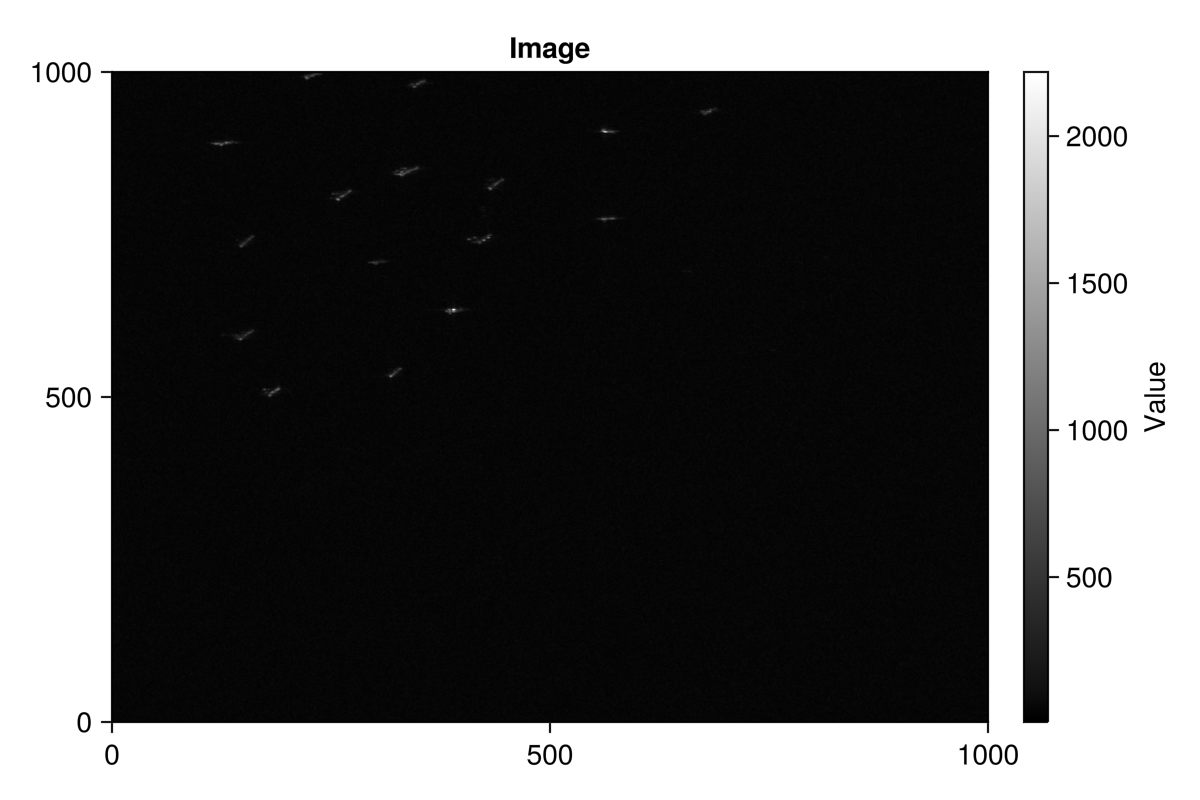

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/kaaso/.julia/packages/Makie/fyNiH/src/scenes.jl:220


GLMakie.Screen(...)

In [4]:
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image")
im = image!(ax, test_img.data[1][:,:], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

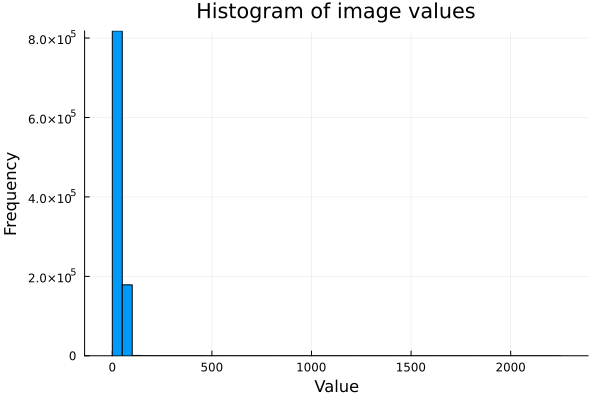

In [5]:
flat_matrix = vec(test_img.data[1])
histogram(flat_matrix, bins=50, xlabel="Value", ylabel="Frequency", title="Histogram of image values", legend=false)

We  need to apply the same preprocessing steps to the new image as we did to the training data. Transformations can be applied using the TransformCompose function

In [6]:
s1_transform = VesselDetection.Ship_detector.Transformation.TransformCompose([
    VesselDetection.Ship_detector.Transformation.absolute,
    x -> VesselDetection.Ship_detector.Transformation.clip_to_valid_range(x, amin=1, amax=65535),
    VesselDetection.Ship_detector.Transformation.to_linear,
    VesselDetection.Ship_detector.Transformation.to_db,
    x -> VesselDetection.Ship_detector.Transformation.to_channels(x, [1, 2]),
    VesselDetection.Ship_detector.Transformation.to_float32,
    
]);


In [7]:
test_img2 = s1_transform(test_img.data);

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/kaaso/.julia/packages/Makie/fyNiH/src/scenes.jl:220


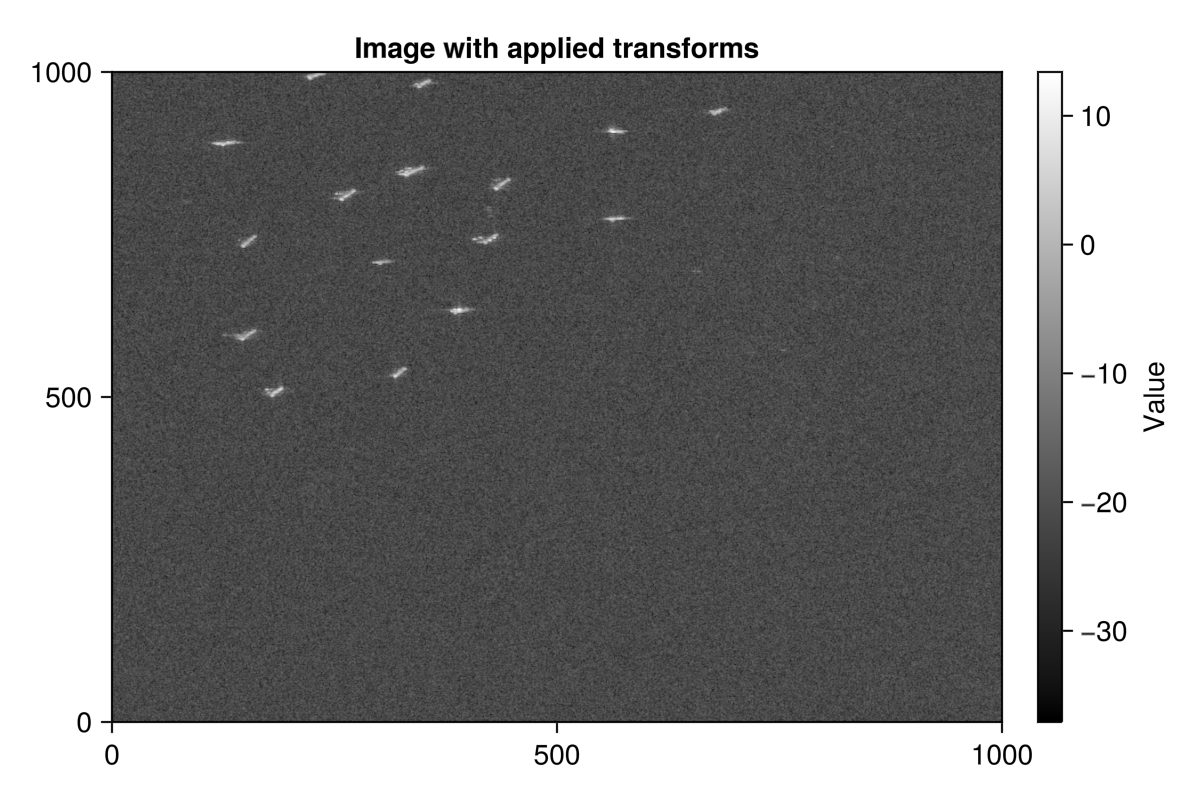

GLMakie.Screen(...)

In [8]:

fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, test_img2[1,:,:], colormap = :greys, )
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

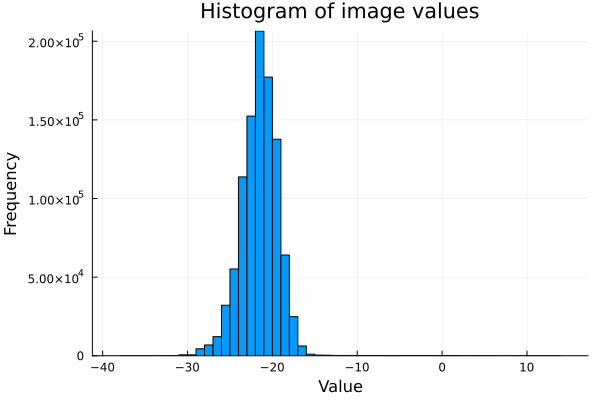

In [9]:
flat_matrix = vec(test_img2[1,:,:])
histogram(flat_matrix, bins=50, xlabel="Value", ylabel="Frequency", title="Histogram of image values", legend=false)

We are not applying furhter normalization, e.g., normalizing to the range [0,1], since this was applied for each subset. 

## Stage 1: CA-CFAR
Back to [Table of Content](#toc)

In the first stage of the workflow, we will detect objects. This stage does not furhter classify the objects. Sometimes, it is assumed that all objects detected on the oceans are ships. However, as we saw in the presentation, this is not always the case.

Many different algorithms can be used to detect objects. Here, we will use a simple CA-CFAR algorithm. The algorithm is implemented in the function `VesselDetection.Detection.CACFAR`. However, you are also welcome to test some of `Images`'s own object detection methods.

for more information on CFAR see, e.g., [CFAR](../Theory/cfar.ipynb).


paramters for the detector

In [10]:
background_window = 41; #pixels in image geometry
guard_window = 31; #pixels in image geometry
probability_for_alarms = 10^(-12);
target_size = 3;

This is the "standard" CFAR. We are only applying it to one band.

In [11]:
image_ca_cfar = VesselDetection.Ship_detector.cell_averaging_constant_false_alarm_rate(test_img2[1,:,:],
                                                                                    background_window ÷ 2,
                                                                                    guard_window ÷ 2,
                                                                                    target_size, 
                                                                                    probability_for_alarms);
image_ca_cfar = VesselDetection.Ship_detector.binarize_array(image_ca_cfar);
objects1 = VesselDetection.Ship_detector.object_locations(image_ca_cfar);
print("Objects: ",size(objects1))


Objects: (53,)

This is a CFAR that also applied morphology. 

In [12]:
image_cp_cfar = VesselDetection.Ship_detector.constant_false_alarm_rate_with_convolution_and_pooling(test_img2[1,:,:],
                                                                                    background_window ÷ 2,
                                                                                    guard_window ÷ 2,
                                                                                    probability_for_alarms);
image_cp_cfar = VesselDetection.Ship_detector.binarize_array(image_cp_cfar);         
objects = VesselDetection.Ship_detector.object_locations(image_cp_cfar);
print("Objects: ",size(objects))                                

Objects: (11,)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/kaaso/.julia/packages/Makie/fyNiH/src/scenes.jl:220


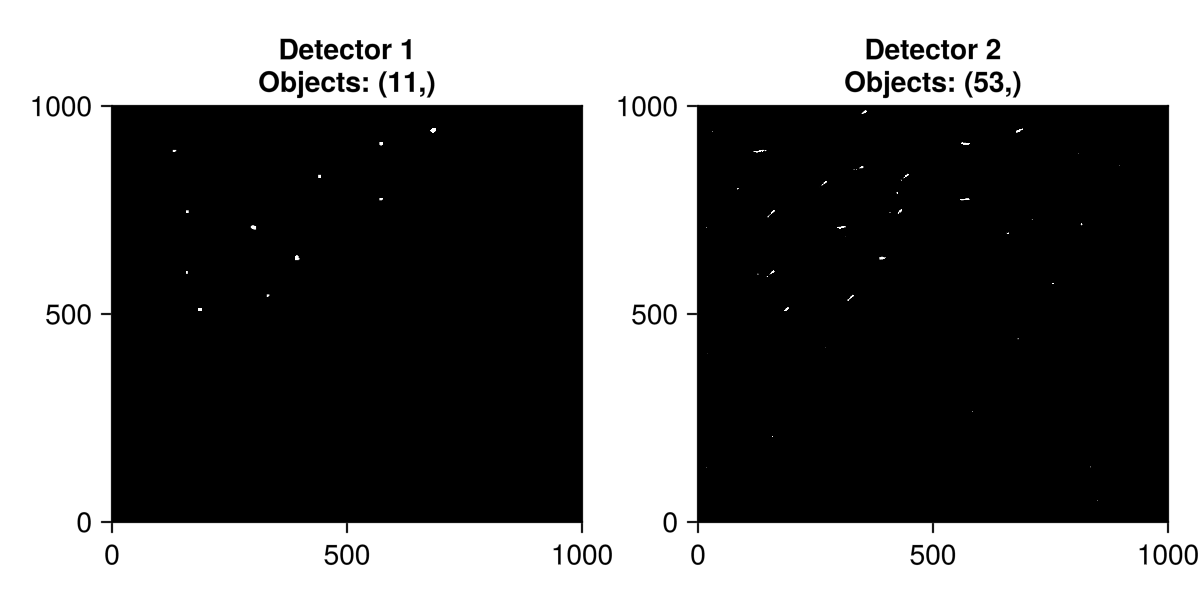

GLMakie.Screen(...)

In [13]:
fig = Figure(resolution = (600, 300))
ax = Axis(fig[1, 1], title = "Detector 1\nObjects: $(size(objects))")
im = image!(ax, image_cp_cfar, colormap = :greys)

ax = Axis(fig[1, 2], title = "Detector 2\nObjects: $(size(objects1))")
im = image!(ax, image_ca_cfar, colormap = :greys)

display(fig)

We clearly see that the classic CA-CFAR (Detector 2) finds very many objects while detector 1 only finds 13. 
In this specific case, it is clear that the classic CA-CFAR is not a good choice. However, this shows the issues in optimizing the CFAR, because Detector 1 might not detect small vessels, such as fishing vessels. 

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Play around with the paramters of the CFAR, and see how much the results change. -> This illustrated the difficulty in optimizing the CFAR.

2. Look at some of the results from both detectors. Ensure that ships indeed are detected. 

#### Plotting

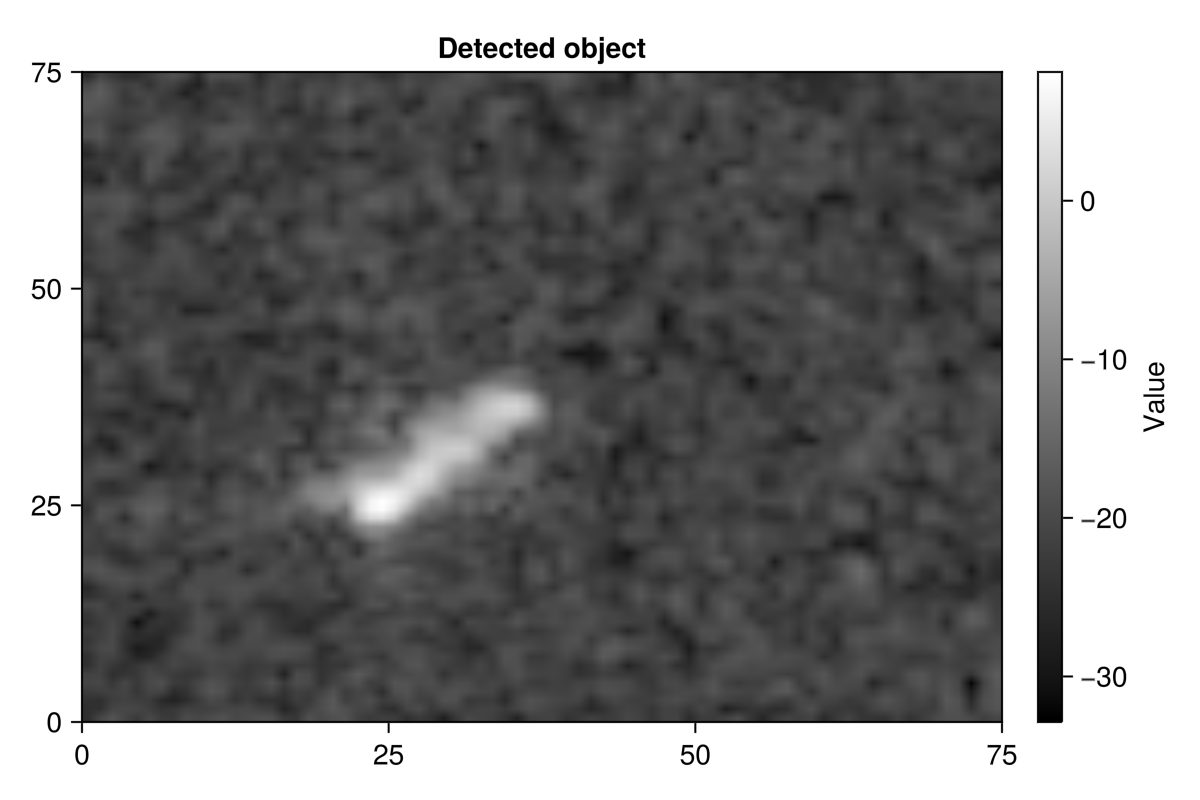

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/kaaso/.julia/packages/Makie/fyNiH/src/scenes.jl:220


GLMakie.Screen(...)

In [14]:

ix = 2
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Detected object")
im = image!(ax, test_img2[1,max(objects[ix][1]-37,1):objects[ix][1]+37,max(objects[ix][2]-37,1):objects[ix][2]+37], colormap = :greys)
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)


## Stage 2: Binary classification
Back to [Table of Content](#toc)

In the second step, we will use the object detector we trained in [Ship binary classification](2_Ship_binary_classification.ipynb) to classify the objects detected in the first step. 

In [15]:
# change to the path to your model.
model = VesselDetection.Ship_detector.Model.Binary_model.load_model("../data/Model/classification_model.bson");

┌ Warning: bson model detected. Bson does not work for Julia 1.8.
└ @ VesselDetection.Ship_detector.Model.Binary_model /Users/kaaso/.julia/packages/VesselDetection/hIEoY/src/ship_detector/model/classifyer/model_util.jl:165


(2, 75, 75)


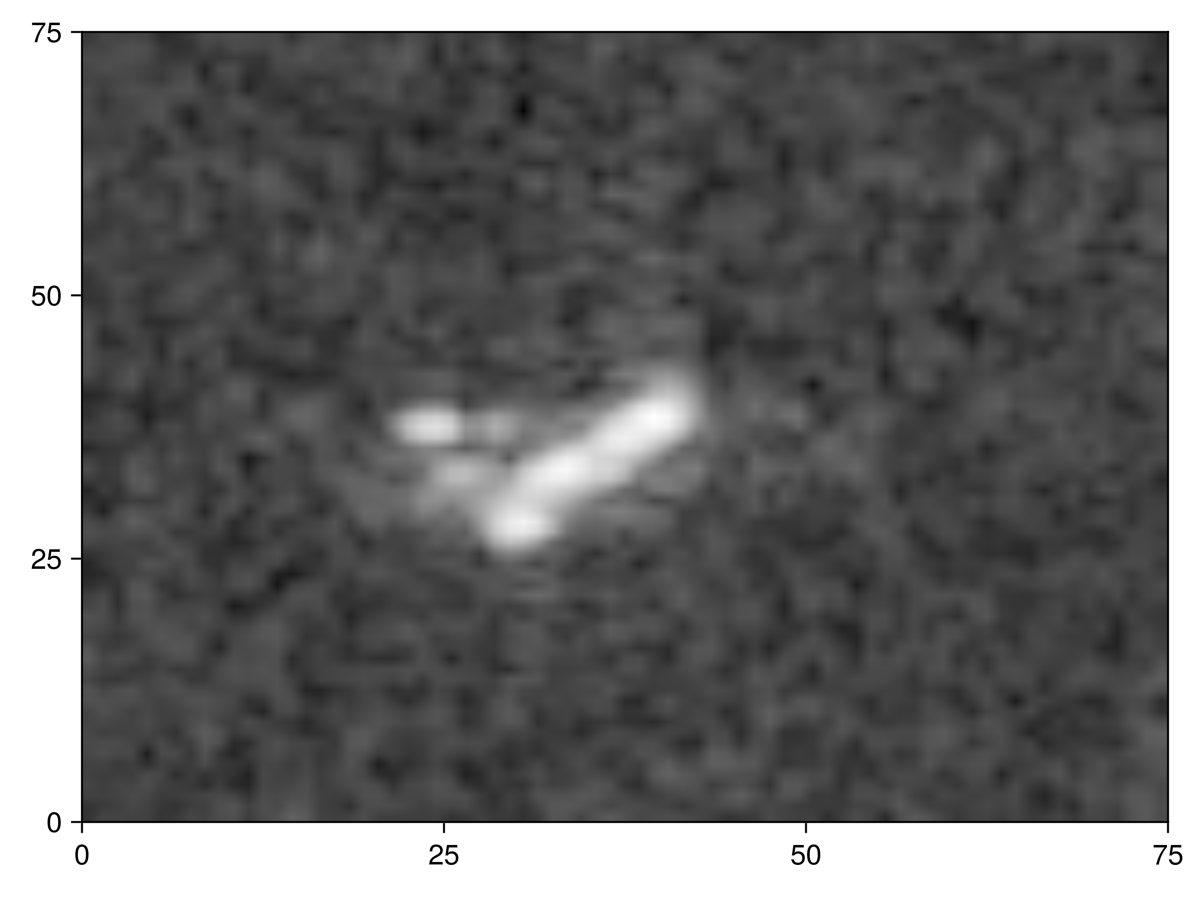

In [16]:
ix = 1
target_1 = test_img2[:,objects[ix][1]-37:objects[ix][1]+37,objects[ix][2]-37:objects[ix][2]+37];
println(size(target_1))
image(target_1[1,:,:], colormap = :greys)

The images need to have the shape 75x75x2xB and be normalized to the range 0-1. 

In [17]:
size(target_1)

(2, 75, 75)

In [18]:
#changing order of dims
target_1 = permutedims(target_1, [2, 3, 1]);
# adding the batch dimension (could also just concatanate the many subsets on the 4th dim.)
target_1 = reshape(target_1, (75, 75, 2,1));
# noamlize the bands
target_1 = VesselDetection.Ship_detector.Model.normalize_bands(target_1);

We can not classify the subset. 

``probability > threshold --> iceberg``

``probability < threshold --> ship``

In [19]:
println(VesselDetection.Ship_detector.Model.Binary_model.classify(input =target_1, model = model,threshold = 0.25))

Dict{String, Real}("probability" => 0.0003300564f0, "ship" => true)


<div class="alert alert-block alert-info"> <b>Task: </b>

1. See what the estimates are for the other objects.

2. Now try to classify a subset without any object. You will properbly get a log score, i.e., a ship. Why is this the case?

3. Think about the drawbacks of this approach.